# Training of PigNPi

In [5]:
import math
import pickle as pkl

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from model import GN_force_SiLU
from dataset_prep import data_prep

torch.set_default_dtype(torch.float64)

In [1]:
from dataset_prep import data_prep

folder = "/mnt/c/Users/nikko/OneDrive/Documents/Uni/magistrale/tesi/simulations"
data_prep(folder, "20241028-150849", 1e-3,2.,"datatrain")

In [2]:
square_flag = False

In [6]:
with open('datatrain.pkl', 'rb') as f:
    simulation_data = pkl.load(f)

In [7]:
vel = simulation_data["velocity"]
num_experiments, simulation_steps, num_nodes, dim = vel.shape

In [8]:
num_experiments, simulation_steps, num_nodes, dim

(130, 10000, 10, 2)

In [9]:
num_train = 100

In [10]:
# edge_list and edge_feature
edge_list = []
edge_feature = []
for this_edge in simulation_data["edge_list"]:
    edge_list.append([this_edge[0], this_edge[1] ] ) # edge from i to j
    edge_list.append([this_edge[1], this_edge[0] ] ) # edge from j to i
edge_list = np.array(edge_list) # shape [num_edge, 2]

In [11]:
node_drag = simulation_data["drag_coefficient"]

In [12]:
node_feature = np.concatenate((simulation_data["position"], node_drag), axis=-1)
print(node_feature.shape)

(130, 10000, 10, 3)


In [13]:
# for flattening first two dimensions
node_feature_flatten = []
vel_flatten = []
for i in range(num_experiments):
    for j in range(simulation_steps):
        node_feature_flatten.append(node_feature[i, j] )
        vel_flatten.append(vel[i,j])

In [14]:
training_node_X = np.array(node_feature_flatten[num_train:])
training_node_Y = np.array(vel_flatten[num_train:])

testing_node_X = np.array(node_feature_flatten[:num_train])
testing_node_Y = np.array(vel_flatten[:num_train])

In [15]:
# model configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

aggr = 'add'
hidden = 100
msg_dim = dim

# n_f = data.shape[3]
n_f = 1 * dim + 1 # node position, node drag
model = GN_force_SiLU(n_node = num_nodes, n_f=n_f, msg_dim=msg_dim, ndim=dim, hidden=hidden, aggr=aggr).to(device)

In GN_force_SiLU, n_node is : 10


In [16]:
edge_list = np.transpose(edge_list)
print("edge_list shape: {}".format(edge_list.shape) )
print(edge_list.dtype)

edge_list shape: (2, 90)
int64


In [17]:
batch_size = 16
training_example_number = len(training_node_X)
testing_example_number = len(testing_node_X)

trainloader = DataLoader(
    [Data(
        x = torch.from_numpy(training_node_X[i]),
        edge_index = torch.tensor(edge_list, dtype=torch.long),
        y = torch.from_numpy(training_node_Y[i]) )  for i in range(training_example_number ) ],
    batch_size=batch_size,
    shuffle=True
    )

testloader = DataLoader(
    [Data(
        x = torch.from_numpy(testing_node_X[i]),
        edge_index = torch.tensor(edge_list, dtype=torch.long),
        y = torch.from_numpy(testing_node_Y[i]) )  for i in range(testing_example_number ) ],
    batch_size=batch_size,
    shuffle=False
)

In [18]:
def cmpt_loss(input_dataloader, ogn_model):
    total_loss = 0.0; num_items = 0
    for ginput in input_dataloader:
        x = ginput.x.to(device)
        true_y = ginput.y.to(device)
        edge_index = ginput.edge_index.to(device)
        edge_feature = None
        # ginput.batch = ginput.batch.to(device) # https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches
        predicted_y = ogn_model(x, edge_index, edge_feature)
        if square_flag:
            loss = torch.sum((true_y - predicted_y) **2 )
        else:
            loss = torch.sum(torch.abs(true_y - predicted_y) )
        total_loss += loss.item()
        num_items += int(ginput.batch.shape[-1]) # all the nodes number in this batch
    return total_loss / num_items

In [19]:
init_lr = 1e-3
# init_lr = 5e-4

opt = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-8)
total_epochs = 200 # training epochs

batch_per_epoch = math.ceil(training_example_number / batch_size )

sched = OneCycleLR(opt, max_lr=init_lr,
                    steps_per_epoch=batch_per_epoch,#len(trainloader),
                    epochs=total_epochs, final_div_factor=1e5)

In [20]:
initial_training_loss = cmpt_loss(trainloader, model)


KeyboardInterrupt: 

In [18]:
initial_training_loss

73.12524404689806

In [19]:
training_loss_history = []
testing_loss_history = []
for epoch in tqdm(range(0, total_epochs)):
# for epoch in range(3):

    total_loss = 0.0
    i = 0
    num_items = 0
    # the original code here can deal with the cases: 1. batch_per_epoch > len(trainloader); 2. batch_per_epoch < len(trainloader)
    # but let's go through the whole training dataset per epoch
    # while i < batch_per_epoch:
    for ginput in trainloader:
        # if i >= batch_per_epoch:
        #     break
        opt.zero_grad()
        x = ginput.x.to(device)
        true_y = ginput.y.to(device)
        edge_index = ginput.edge_index.to(device)
        edge_feature = None

        predicted_y = model(x, edge_index, edge_feature)

        if square_flag:
            loss = torch.sum((true_y - predicted_y) **2 )
        else:
            loss = torch.sum(torch.abs(true_y - predicted_y) )

        loss.backward()
        opt.step()
        sched.step()
        total_loss += loss.item()
        i += 1
        num_items += int(ginput.batch.shape[-1]) # all the nodes number in this batch

    training_loss = total_loss / num_items # the average on the node level
    testing_loss = cmpt_loss(testloader, model)
    if epoch % 5 == 0:
        print("LOSS -- train: {}; test:{}".format(training_loss, testing_loss) )

    training_loss_history.append(training_loss)
    testing_loss_history.append(testing_loss)

100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


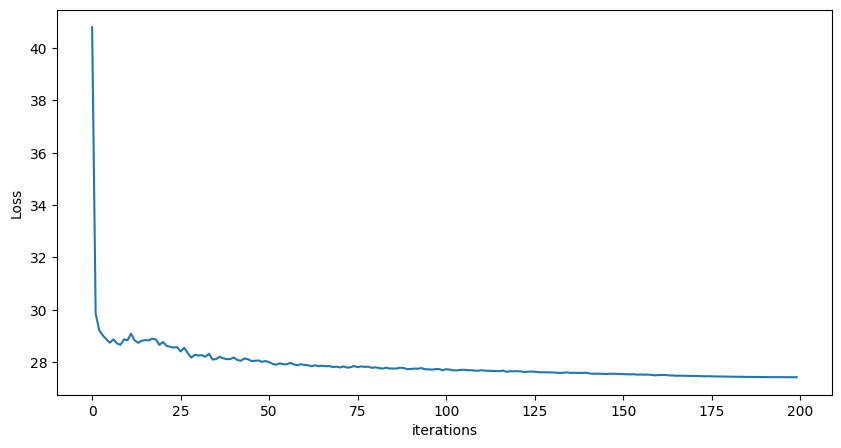

In [22]:
plt.figure(figsize=(10,5))
plt.plot(training_loss_history, label = "training loss")
plt.plot(testing_loss_history, label = "testing loss")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()